# Face Generation

Jay Urbain  
jay.urbain@gmail.com

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

floyd run --gpu --data R5KrjnANiKVhLWAkpXhNBe --mode jupyter env=tensorflow-1.0

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

['/input/mnist/image_13119.jpg', '/input/mnist/image_32703.jpg', '/input/mnist/image_26142.jpg', '/input/mnist/image_58756.jpg', '/input/mnist/image_42180.jpg', '/input/mnist/image_21138.jpg', '/input/mnist/image_34161.jpg', '/input/mnist/image_9501.jpg', '/input/mnist/image_40722.jpg', '/input/mnist/image_18123.jpg', '/input/mnist/image_20409.jpg', '/input/mnist/image_33432.jpg', '/input/mnist/image_59485.jpg', '/input/mnist/image_5226.jpg', '/input/mnist/image_41451.jpg', '/input/mnist/image_25413.jpg', '/input/mnist/image_13830.jpg', '/input/mnist/image_52305.jpg', '/input/mnist/image_39883.jpg', '/input/mnist/image_1662.jpg', '/input/mnist/image_10284.jpg', '/input/mnist/image_42898.jpg', '/input/mnist/image_34879.jpg', '/input/mnist/image_53034.jpg', '/input/mnist/image_2391.jpg']


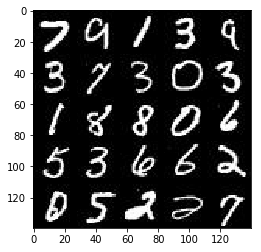

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
print(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images])
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

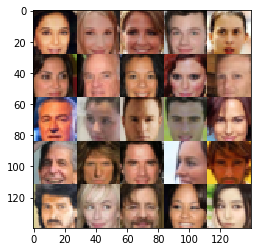

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))  
    Z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=(None))
    return input_images, Z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function 
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):

        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', 
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * x1, x1)
         # 14x14x64
            
        # layer 2
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='SAME',
                             kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # layer 3
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='SAME',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
         # 4x4x256
            
        # flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # Fully connected input layer connected
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256
        
        # Convolution transpose layers
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 3, strides=1, padding='SAME',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_model_fake)))
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model                
    _, image_width, image_height, image_channels = data_shape
    
    # model_inputs: input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # model_loss: d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # model_opt: d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Batch counter
    batch_count = 0
    
    # Number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6065... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 1.9783... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 3.9806
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 1.9336
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.1551
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.1267
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.7264


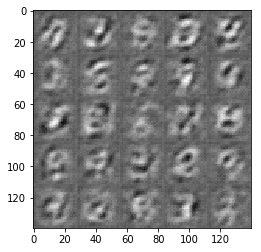

Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.5605


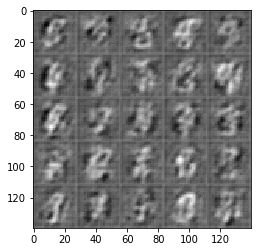

Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.5100
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.9192
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.0532
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 1.1863
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 1.9117
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 1.6164
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 0.8648


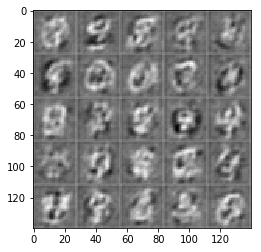

Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 1.7244
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 1.1998
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.1227
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 2.2407
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.6605
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 1.8618
Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 1.4227
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.8811


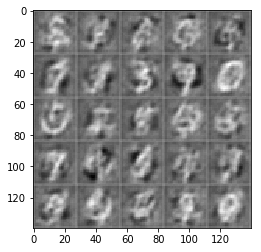

Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 1.2042
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 2.4101
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 1.2781
Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 1.5696
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.1064
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 1.8334
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.6417


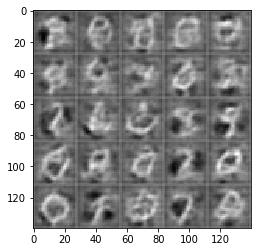

Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 1.1604
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.2027
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.2921
Epoch 1/2... Discriminator Loss: 0.7894... Generator Loss: 1.4991
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 1.9345
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 1.3989
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 1.0430
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.3662
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 1.1993


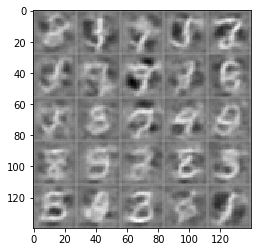

Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 2.4223
Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.6983
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.1392... Generator Loss: 0.7493
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 1.8773
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.5032


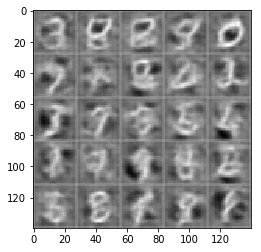

Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.1314
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.7907
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 1.1608
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 1.5458
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.5584
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.5101
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 1.2056
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.8858


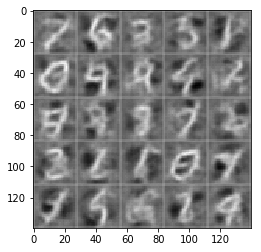

Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 0.9894... Generator Loss: 0.8856
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.9498
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.5030
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.3477
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 0.9790... Generator Loss: 0.9728


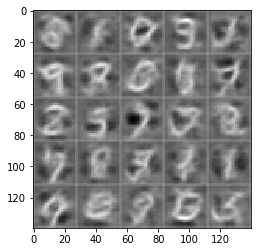

Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 1.3372
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.8180
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.6054
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 0.9726


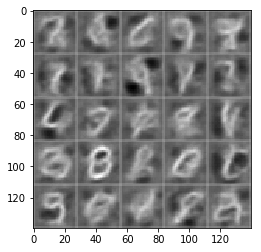

Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.2720
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.2097
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.6778


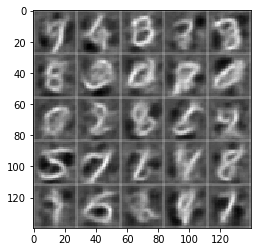

Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 1.8230
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 2.3104
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.4703
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 1.9809
Epoch 1/2... Discriminator Loss: 0.8512... Generator Loss: 1.1172
Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 0.9492


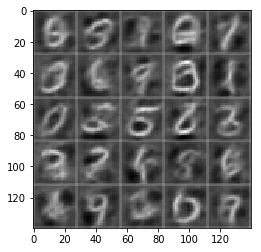

Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 1.4187
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 1.1190
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.5816
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 2.5446
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.2471
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.8447


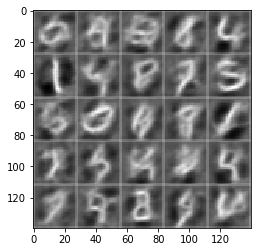

Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 0.8491
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.0032
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.9073
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 1.9865


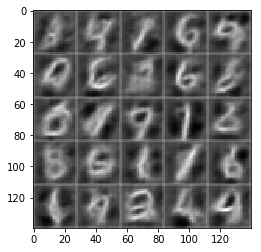

Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 0.7001... Generator Loss: 1.7084
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.1284
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.5958... Generator Loss: 0.4918
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.2558
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.7538... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.9580


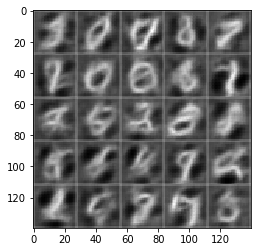

Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.3791
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 0.9316
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 1.4452


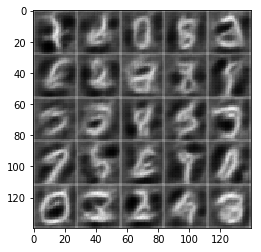

Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 1.2917
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 0.8846
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 1.2868
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 1.1384
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.0487... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.9400... Generator Loss: 0.2877
Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.8426


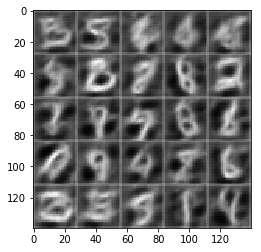

Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 0.9744
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.6230
Epoch 1/2... Discriminator Loss: 0.7818... Generator Loss: 1.3727
Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 1.5191
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 1.9876
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.4600
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.6336


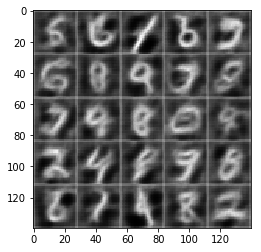

Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.0427
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.6249
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 0.9730
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.1801
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 2.3754
Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 1.4352


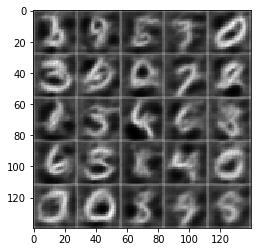

Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.4186
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 2.5362
Epoch 2/2... Discriminator Loss: 0.7719... Generator Loss: 1.3307
Epoch 2/2... Discriminator Loss: 0.8754... Generator Loss: 1.3073
Epoch 2/2... Discriminator Loss: 0.6983... Generator Loss: 1.4467
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.0076
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 0.9807


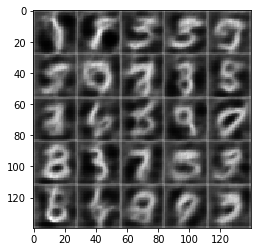

Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.5263
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 1.9910
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 1.1525
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 0.9158... Generator Loss: 1.6697
Epoch 2/2... Discriminator Loss: 1.4845... Generator Loss: 0.4803


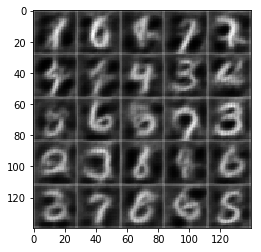

Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.5010
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 2.5772
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 0.8101
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.1873
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.1251


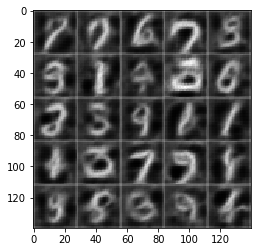

Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.5354
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 1.1077
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.3613
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 2.1031
Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.8014
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.7613


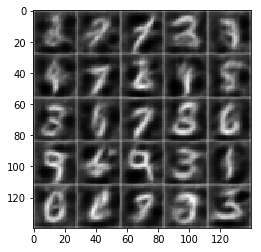

Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 2.4384
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.1397
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 1.6965
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.7560


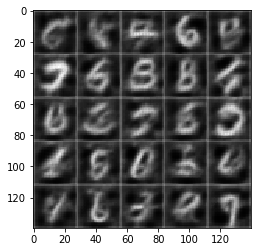

Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 1.4396
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.5658... Generator Loss: 2.9070
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.1359
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.0909
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.3032
Epoch 2/2... Discriminator Loss: 0.8538... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.1051


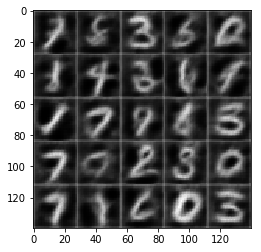

Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 2.0662
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 2.1066
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 0.9112... Generator Loss: 2.0759
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 1.8329
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.3709


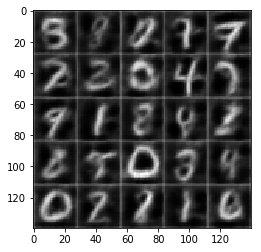

Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.5298
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 2.1804
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 2.3044
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.7195
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.4815
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.8764


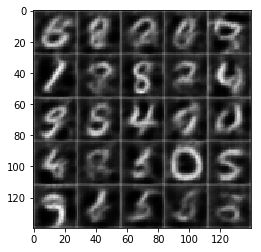

Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.4669
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.1249
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 1.1965
Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 1.3787
Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 1.6461
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.1891
Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 2.1105
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.6099
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 1.1142
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.2864


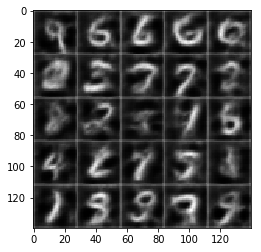

Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 2.6037
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.0470
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 2.8095
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.9980
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.6547
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.5912
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.3042
Epoch 2/2... Discriminator Loss: 0.7217... Generator Loss: 1.3863


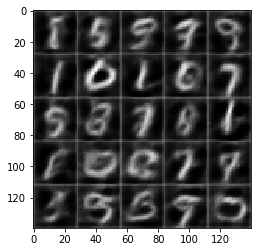

Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.5966
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.9528
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.5426
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.1331
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.0025
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.4907


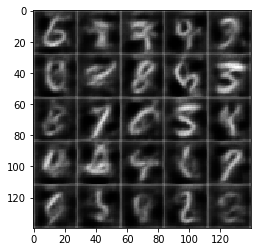

Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 1.9147
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.9025
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.2193
Epoch 2/2... Discriminator Loss: 0.6836... Generator Loss: 1.4149


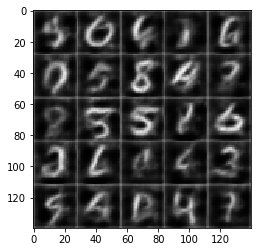

Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 2.8334
Epoch 2/2... Discriminator Loss: 0.8949... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 1.2960
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 1.1705
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.6048
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.2167


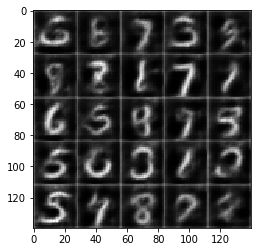

Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.3586
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.5638
Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.7520
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.0653
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.7560


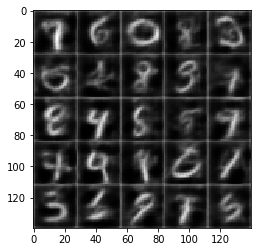

Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.8480
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 1.9164
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.7206
Epoch 2/2... Discriminator Loss: 0.6565... Generator Loss: 1.5965
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 2.0628
Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 1.6579
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 2.4944


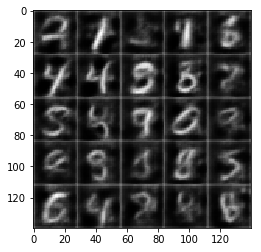

Epoch 2/2... Discriminator Loss: 0.6688... Generator Loss: 1.9578
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.6217
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 2.9085
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.5476
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.7901
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.4086
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.7647
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.0156


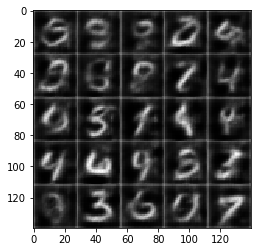

Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 2.8367
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 0.6877... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 1.9700
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 1.9044
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 0.7067... Generator Loss: 1.9775


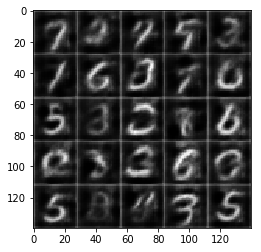

Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 1.4210
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 0.9229
Epoch 2/2... Discriminator Loss: 1.1569... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.7202... Generator Loss: 0.4372
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.2821
Epoch 2/2... Discriminator Loss: 0.5886... Generator Loss: 1.9905
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.2011


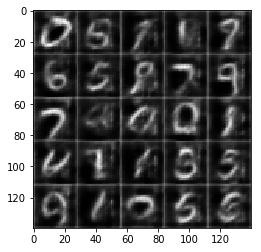

Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.1480
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 2.2596
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 2.7438


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 3.8974
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 2.8402
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.5117
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8038


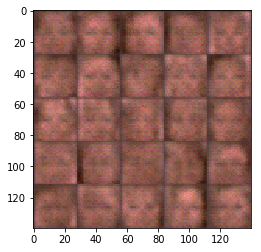

Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 2.1572
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 2.0127
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7305


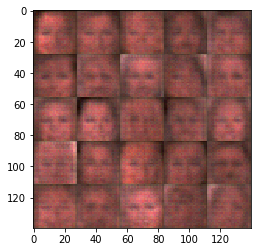

Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.3205
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.7864


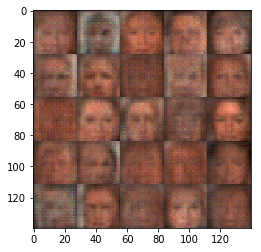

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8403


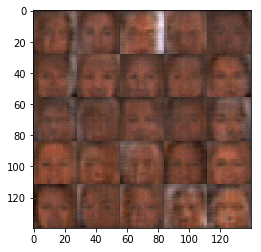

Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.1461


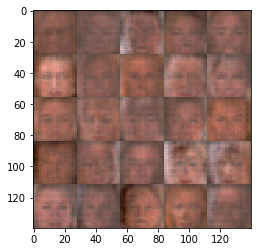

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.0636


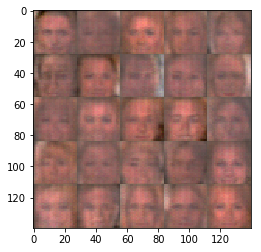

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8765


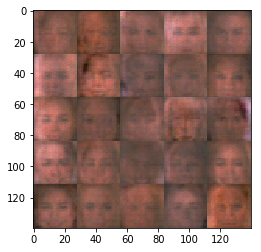

Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9326


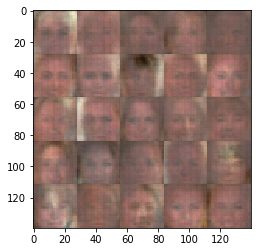

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.2520


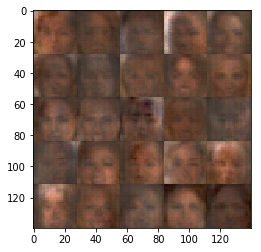

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 1.1474
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.5245


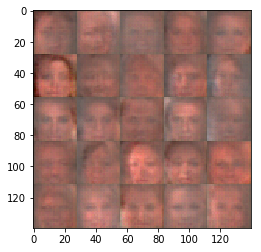

Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.0723


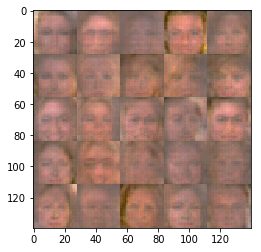

Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0277


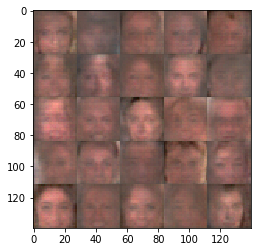

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.0771


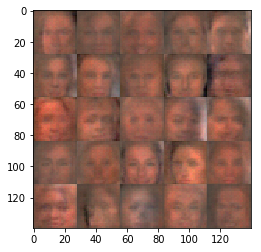

Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6698


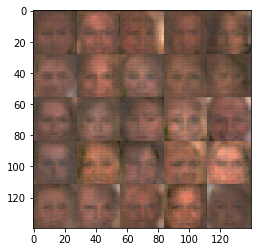

Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8140


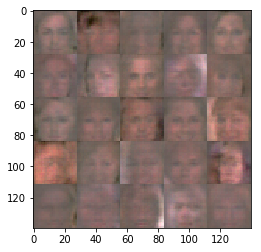

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.0354
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.9767


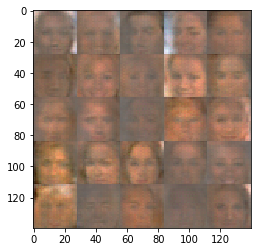

Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.4654
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.0922


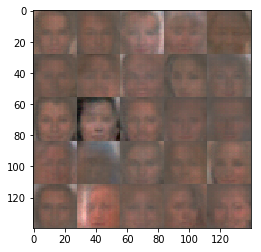

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.3624


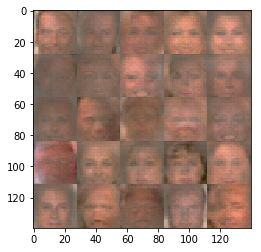

Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8821


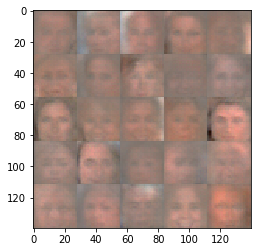

Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7933


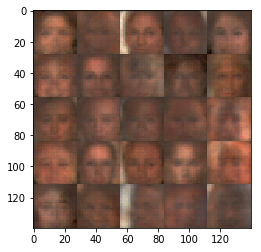

Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.6507


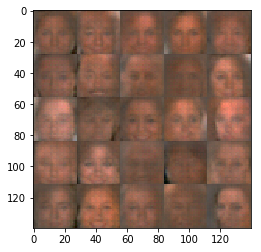

Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7628


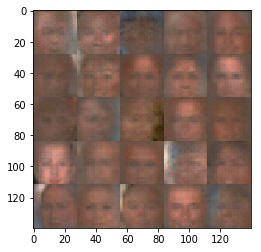

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7865


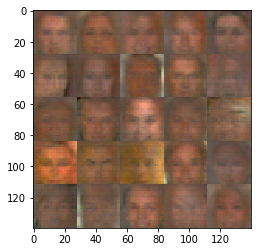

Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8369


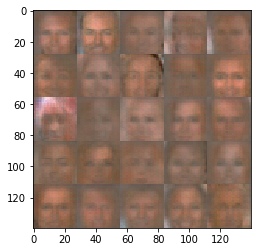

Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.4574
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.2646


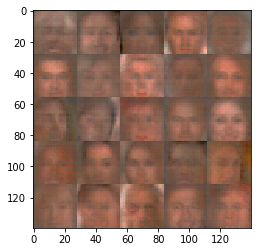

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.2322


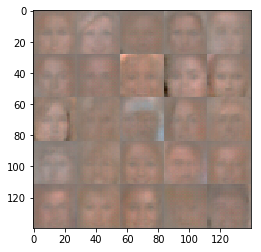

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8204


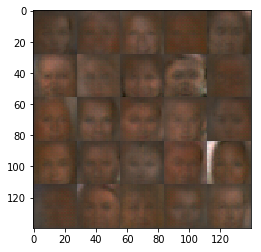

Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 1.3541


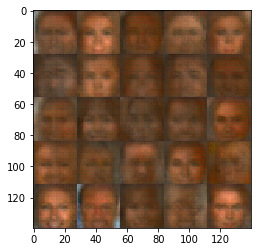

Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.9866


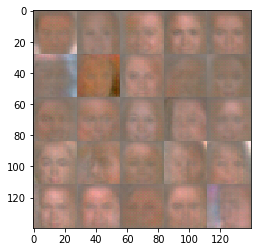

Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6672


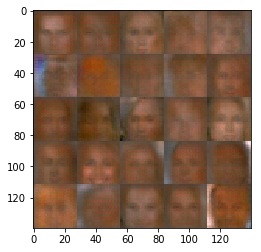

Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.8517


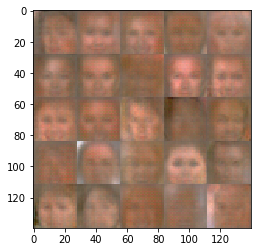

Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8955


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.